# Linear Regression with Elastic Net

## Import Libraries and Load Dataset

In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for the modeling.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Linear regression will use python statsmodels library instead of sickit learn because the former offers a more comprehensive report
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load the data
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_removedskew_outliers3_0_NoW_tn20_mcp00.10.parquet')

## Modelling

In [ ]:
# Step 1: Split data into features and target

target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train an Elastic Net model with Cross-Validation
enet_cv = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)
enet_cv.fit(X_train_scaled, y_train)

## NOTE: the model ElasticNetCV itself is a type of linear regression model that incorporates Elastic Net regularization.

# Step 5: Display best parameters (alpha and l1_ratio)
# print("Best alpha:", enet_cv.alpha_)
# print("Best l1_ratio:", enet_cv.l1_ratio_)

#Results:
# Best alpha: 0.029418569473813518
# Best l1_ratio: 0.9

# Step 6: Make predictions
y_train_pred = enet_cv.predict(X_train_scaled)
y_test_pred = enet_cv.predict(X_test_scaled)

# Model Evaluation

# Step 7: Evaluate the model with R-squared and MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse_lr2 = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2_lr2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE lr2: {test_mse_lr2}")
print(f"Training R2: {train_r2}")
print(f"Test R2 lr2: {test_r2_lr2}")

# Note: a Cross Validation was here performed too. The results were:
# Cross-validated R-squared scores: [0.85771661 0.85134637 0.89473865 0.89235247 0.89237902]
# Mean R-squared across folds: 0.8777066226101098
# Standard deviation of R-squared across folds: 0.019049057797127088

# Since both the test R² and cross-validated R² scores are around 0.86-87, it implies that the model’s performance is consistent across different subsets and also aligns with the hold-out test set. 
# This consistency is a sign of a well-balanced model.


Best alpha: 0.029418569473813518
Best l1_ratio: 0.9


## Feature Importance

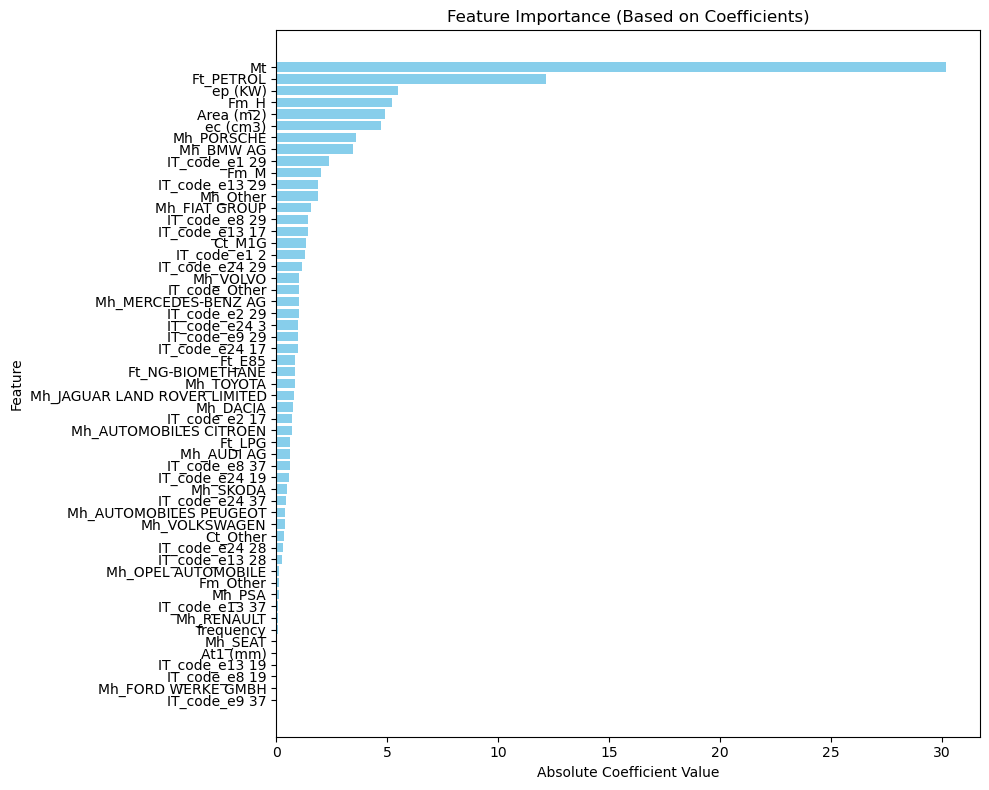

In [24]:
# Get feature importance (absolute value of coefficients)
feature_importance = np.abs(enet_cv.coef_)
feature_names = X.columns  # Assuming X is the DataFrame with feature names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Based on Coefficients)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Ensemble XGBoost (Extreme Gradient Boosting)

## Import Libraries and Load Dataset

In [ ]:
# Import staandard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for the modeling.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Linear regression will use python statsmodels library instead of sickit learn because the former offers a more comprehensive report
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import shap

from sklearn.model_selection import cross_val_score

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load the data
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_removedskew_outliers3_0_NoW_tn20_mcp00.10.parquet')

## Data Preparation and XG Boost with Grid Search (Execution time: 120 + min)

In [ ]:
# Step 1: Prepare the data
X = df.drop(columns=['Ewltp (g/km)'])  # Features
y = df['Ewltp (g/km)']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Note: XGBoost with tree-based models does not require scaling of numerical variables.

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting rounds
    'max_depth': [3, 5, 7],          # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.7, 0.8, 1.0],    # Fraction of samples to be used for fitting each base learner
    'colsample_bytree': [0.7, 0.8, 1.0] # Fraction of features to consider for each split
}

# Step 2: Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Step 3: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Negative MSE as scoring metric (GridSearchCV expects a score, so we use neg MSE)
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Step 4: Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert back to positive MSE for interpretation
print("Best Parameters:", best_params)
print("Best MSE from Grid Search:", best_score)

# Step 5: Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)
test_r2_best = r2_score(y_test, y_test_pred_best)

print(f"Best Model Test MSE: {test_mse_best}")
print(f"Best Model Test R-squared: {test_r2_best}")


#Results: 
#Fitting 3 folds for each of 243 candidates, totalling 729 fits
#Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
#Best MSE from Grid Search: 27.69585418701172
#Best Model Test MSE: 27.76150894165039
#Best Model Test R-squared: 0.9762125611305237

# Note: XG Boost was first run without Grid Search. Results were:
# Training MSE: 32.39582061767578
# Test MSE XG: 32.95991516113281
# Training R-squared: 0.9722272753715515
# Test R-squared XG: 0.9717583060264587
# Not an impressive improvement

# Note: Cross Validation (CV = 5) were also performedUsing the values found via Grid Search. These were the results:
#Cross-validated R-squared scores: [0.95309782 0.95203137 0.97476494 0.97112    0.95989263]
# Mean R-squared across folds: 0.9621813535690308
# Standard deviation of R-squared across folds: 0.009263012896971545

# Interpretation:
# These results imply that the XGBoost model is performing well, with high R-squared scores across all folds and low variability. 
# This level of consistency and high performance across folds is a strong indicator that the model is well-suited to our dataset and problem, 
# and no immediate further adjustments are needed.


Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\alexa\anaconda3\envs\aug24_bds_int---co2\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Best MSE from Grid Search: 27.69585418701172
Best Model Test MSE: 27.76150894165039
Best Model Test R-squared: 0.9762125611305237


Explanation of Hyperparameters Chosen
- n_estimators: Controls the number of boosting rounds. Lower values (50-150) keep memory usage manageable.
- max_depth: Depth of each tree. Values of 3, 5, and 7 provide a balance between model complexity and performance.
- learning_rate: Step size shrinkage to prevent overfitting. Lower values (0.01-0.2) help maintain model stability.
- subsample and colsample_bytree: Control the fraction of samples and features used per tree. Smaller values reduce variance and memory load.

With this setup, I hope to be able to tune the XGBoost model efficiently within my system's memory limits (16 GB RAM).


## Feature importance : SHAP values

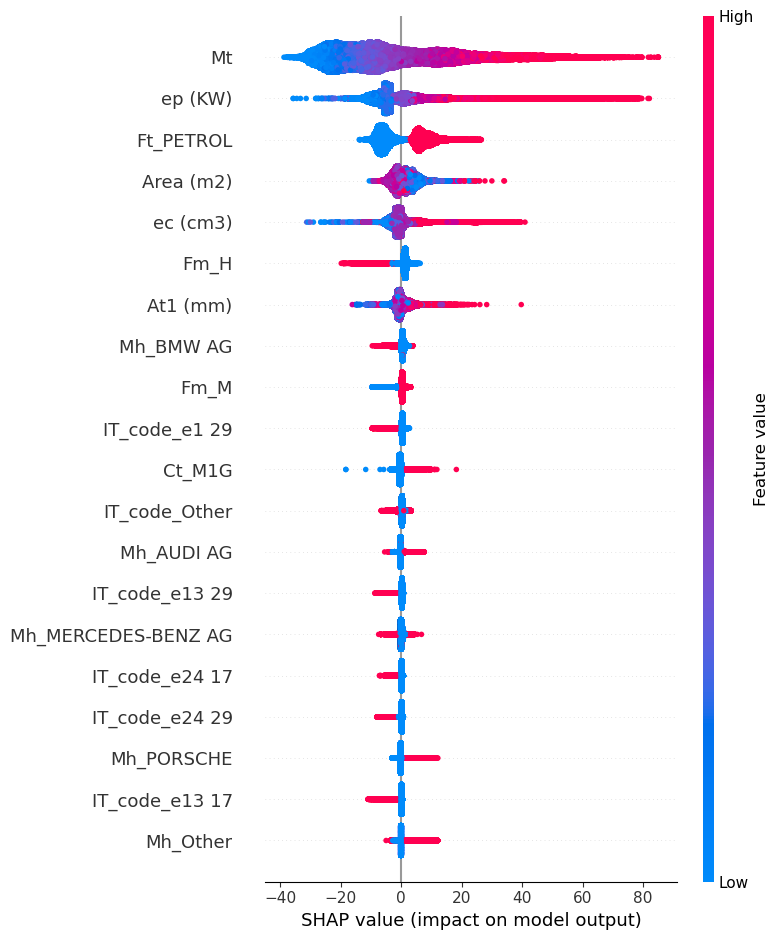

In [13]:
# SHAP does not necessarily require scaling. However, scaling may still be beneficial for interpretability. 

# Scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data to DataFrame for SHAP compatibility and assign feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


# Step 2: Initialize and train the XGBoost model


xgb_model = xgb.XGBRegressor(
    n_estimators=150,         # Best n_estimators from Grid Search
    max_depth=7,              # Best max_depth from Grid Search
    learning_rate=0.2,        # Best learning_rate from Grid Search
    colsample_bytree=1.0,     # Best colsample_bytree from Grid Search
    subsample=0.8,            # Best subsample from Grid Search
    random_state=42
)

xgb_model.fit(X_train_scaled_df, y_train)

# Step 3: Make predictions
y_train_pred = xgb_model.predict(X_train_scaled_df)
y_test_pred = xgb_model.predict(X_test_scaled_df)

# Step 4: SHAP Analysis
# Create a SHAP explainer object for the XGBoost model

explainer = shap.TreeExplainer(xgb_model)

# Explain predictions on the test set
shap_values = explainer(X_test_scaled_df)  # Do not use .values here

# Visualize SHAP values using a force plot for the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test_scaled_df.iloc[0], feature_names=X.columns)

# Alternatively, use a summary plot for an overview of feature importance
shap.summary_plot(shap_values.values, X_test_scaled_df, feature_names=X.columns)


Interpretation: 


Guide

1- Feature Importance:

The features are ranked vertically based on their importance. Features at the top have a larger impact on the model's predictions.
The color of the dots represents the direction of the feature's impact:
Red dots indicate features that increase the prediction (positive impact).
Blue dots indicate features that decrease the prediction (negative impact).

2- Feature Value Distribution:

The horizontal spread of the dots for a feature shows the range of values that the feature takes in the dataset.
A wider spread indicates a larger variation in the feature's values.

3- Feature Impact on Prediction:

The position of the dots on the horizontal axis shows how much a particular feature value contributes to the model's prediction.
Dots farther to the right indicate a larger positive contribution, while dots farther to the left indicate a larger negative contribution.


# Dense Neural Network (DNN) 

## Import Libraries and Load Dataset

In [ ]:
# Import staandard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for the modeling.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load the data
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_removedskew_outliers3_0_NoW_tn20_mcp00.10.parquet')


Data Preparation 

In [7]:
# Step 1: Split data into features and target

target_column = 'Ewltp (g/km)'
X = df.drop(columns=[target_column])
y = df[target_column]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale numerical features (assuming X is already preprocessed with categorical encoding)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling the target variable as well (optional but can be helpful)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Step 3: Further split X_train_scaled and y_train_scaled into training and validation sets
X_train_partial, X_val, y_train_partial, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)


## Modelling and summary

# Step 4: Build the Neural Network Model

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Explicitly define the input shape
    Dense(64, activation='relu'),
    Dropout(0.2),  # Dropout layer to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with one neuron for regression output
])

# Compile the model with MSE as the loss function and Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 5: Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Step 6: Train the Model
history = model.fit(
    X_train_partial, y_train_partial,
    validation_data=(X_val, y_val),
    epochs=20,              # Reduced epochs - help manage memory usage.
    batch_size=16,          # Smaller batch size- help manage memory usage.
    callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

Epoch 1/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - loss: 0.1036 - mse: 0.1036 - val_loss: 0.0816 - val_mse: 0.0816
Epoch 2/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - loss: 0.0567 - mse: 0.0567 - val_loss: 0.0986 - val_mse: 0.0986
Epoch 3/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 107s 1ms/step - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0901 - val_mse: 0.0901
Epoch 4/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 5/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 110s 1ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0883 - val_mse: 0.0883
Epoch 6/20
81112/81112 ━━━━━━━━━━━━━━━━━━━━ 111s 1ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0983 - val_mse: 0.0983
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# Step 7: Evaluate the Model on the Test Set

# Transform the predictions back to the original scale
y_train_pred = scaler_y.inverse_transform(model.predict(X_train_scaled).flatten().reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(model.predict(X_test_scaled).flatten().reshape(-1, 1))

# Transform y_train and y_test back to the original scale
y_train_orig = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

train_mse = mean_squared_error(y_train_orig, y_train_pred)
test_mse_DNN1 = mean_squared_error(y_test_orig, y_test_pred)
train_r2 = r2_score(y_train_orig, y_train_pred)
test_r2_DNN1 = r2_score(y_test_orig, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE DNN1: {test_mse_DNN1}")
print(f"Training R-squared: {train_r2}")
print(f"Test R-squared DNN1: {test_r2_DNN1}")

50695/50695 ━━━━━━━━━━━━━━━━━━━━ 42s 832us/step
12674/12674 ━━━━━━━━━━━━━━━━━━━━ 11s 841us/step
Training MSE: 130.92611694335938
Test MSE DNN1: 131.5028076171875
Training R-squared: 0.8877578973770142
Test R-squared DNN1: 0.8873218297958374


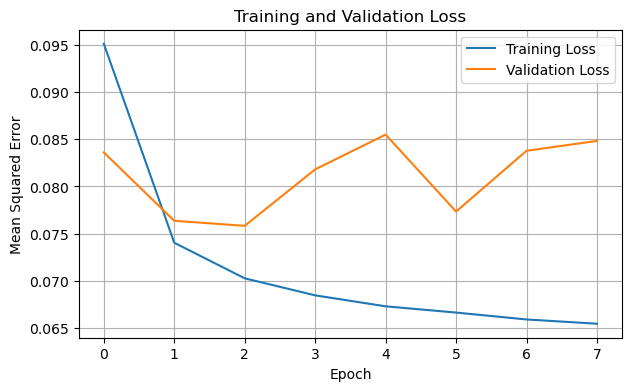

In [24]:
# Step 8: Plot Training and Validation Loss
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Interpretation: 

Initial Decrease: Both training and validation loss decrease significantly in the initial epochs, indicating that the model is learning and improving its performance.
Diverging Losses: After a few epochs, the training loss continues to decrease, while the validation loss starts to increase. This is a clear sign of overfitting.
Overfitting: The model is becoming too complex and is starting to memorize the training data rather than learning generalizable patterns. This leads to poor performance on unseen data, as reflected by the increasing validation loss.

A well-trained model should ideally have both training and validation loss decreasing and converging to a low value.

Possible Solutions used to address overfitting:

- Early Stopping: Implement early stopping to stop the training process when the validation loss starts to increase.
- Regularization: Introduce regularization techniques like L1 or L2 regularization to penalize model complexity and prevent overfitting.
- Model Architecture: Experiment with different model architectures, such as using simpler models or adding dropout layers to reduce overfitting.

**
Two further attempts were made to improve the model aiming to have both training and validation loss decreasing and converging to a low value. Modifications were based on:

- L2 Regularization (Ridge): Added to each dense layer to penalize large weights, which helps control overfitting by encouraging the model to keep weights small.
- Increased Dropout: Raised the dropout rate to 0.3 to further reduce overfitting by randomly dropping more neurons during training.
- Early Stopping: Retained early stopping to halt training if the validation loss does not improve, helping avoid unnecessary epochs.
But also:
-	Increasing test size (to 30%) batch size to 32.

Unfortunately, these changes did not improve the model either by significantly increasing the Test-R-squared or by controlling the behavior of the validation loss curve. 


# Model Comparison

## Import Libraries and Load Dataset

In [4]:
# Import standard libraries
import pandas as pd
import numpy as np
import time  # To measure training time for each model

# Import libraries for the modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV
import xgboost as xgb

# TensorFlow for DNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Github\Data\minimal_withoutfc_dupesdropped_frequencies_area_removedskew_outliers3_0_NoW_tn20_mcp00.10.parquet')


In [5]:
# Step 1: Split data into features and target
target_column = 'Ewltp (g/km)'  # Target column
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale numerical features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scaling the target variable as well (optional but can be helpful)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Instantiate models
LR_model = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)
XG_model = xgb.XGBRegressor(colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=1.0, random_state=42) # using best parameters found

# DNN model setup
X_train_partial, X_val, y_train_partial, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

DNN_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Explicitly define the input shape
    Dense(64, activation='relu'),
    Dropout(0.2),  # Dropout layer to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with one neuron for regression output
])

DNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

history = DNN_model.fit(
    X_train_partial, y_train_partial,
    validation_data=(X_val, y_val),
    epochs=20,              # Reduced epochs to help manage memory usage
    batch_size=16,          # Smaller batch size to help manage memory usage
    callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# List of models to evaluate
models = {
    'Linear Regression': LR_model,
    'XGBoost': XG_model,
    'Dense Neural Network': DNN_model  # Including DNN as a separate case
}

# Store results
results = {}

for name, model in models.items():
    start_time = time.time()  # Track time
    
    # Special handling for DNN model as it requires scaled targets
    if name == 'Dense Neural Network':
        y_pred = DNN_model.predict(X_test_scaled).flatten()
        mse = mean_squared_error(y_test_scaled, y_pred)
        r2 = r2_score(y_test_scaled, y_pred)
        # Cross-validation may not be directly compatible with DNNs; skipping for this model
        cv_r2 = 'N/A'
    else:
        model.fit(X_train_scaled, y_train_scaled)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test_scaled, y_pred)
        r2 = r2_score(y_test_scaled, y_pred)
        cv_r2 = cross_val_score(model, X_train_scaled, y_train_scaled, cv=5, scoring='r2').mean()

    # Store results
    results[name] = {
        'Test MSE': mse,
        'Test R-squared': r2,
        'Cross-validated R-squared': cv_r2,
        'Training Time (seconds)': time.time() - start_time
    }

# Compare results
comparison_df = pd.DataFrame(results).T
print(comparison_df)

Epoch 1/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 105s 1ms/step - loss: 0.1048 - mse: 0.1048 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 2/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 108s 1ms/step - loss: 0.0613 - mse: 0.0613 - val_loss: 0.0709 - val_mse: 0.0709
Epoch 3/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 105s 1ms/step - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 4/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 144s 1ms/step - loss: 0.0563 - mse: 0.0563 - val_loss: 0.0664 - val_mse: 0.0664
Epoch 5/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 101s 1ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 6/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 105s 1ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 7/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 102s 1ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 8/20
80018/80018 ━━━━━━━━━━━━━━━━━━━━ 150s 1ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 9/